# Packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters

In [ ]:
# Parameters
N_paths = 5000
N_steps = 30
batch_size = 128
transaction_cost = 0.0
K = 100
S0 = 100
lr = 1e-4
n_epochs = 50
alpha = 0.95
beta = 0.05
T = 1
r=0.05
sigma=0.2

# Helper functions

In [ ]:
# ----- Black-Scholes path simulator -----
def simulate_paths(model="BS", N_paths=5000, N_steps=30, S0=100, mu=0, sigma=0.2, dt=None):
    if dt is None:
        dt = 1.0 / N_steps
    S_paths = np.zeros((N_paths, N_steps + 1))
    S_paths[:, 0] = S0
    for t in range(1, N_steps + 1):
        z = np.random.randn(N_paths)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S_paths


def bs_call_delta(S, K, T, r, sigma):
    """
    Vectorized Black-Scholes delta for a European call option.
    S: [n_paths, n_steps] spot prices
    K: strike (scalar)
    T: [n_steps] time to maturity for each step (in years)
    r: risk-free rate (scalar)
    sigma: volatility (scalar)
    Returns:
        delta: [n_paths, n_steps] delta for each path and step
    """
    # Avoid division by zero at T=0
    T = np.maximum(T, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Data generation

In [ ]:
# Data generation
S_paths = simulate_paths(N_paths=N_paths, N_steps=N_steps, S0=S0)

n_paths = S_paths.shape[0]
dt = T / N_steps
S0 = 100

# Build features and labels for every path and time
all_X = []
all_y = []

# Vectorized version:
for i in range(n_paths):
    for t in range(N_steps):
        spot = S_paths[i, t]
        ttm = T - t*dt
        moneyness = spot / K
        # True BS delta
        d1 = (np.log(spot / K) + (r + 0.5 * sigma**2) * ttm) / (sigma * np.sqrt(ttm + 1e-8))
        bs_delta = norm.cdf(d1)
        all_X.append([spot/S0, ttm/T, moneyness])  # Normalize price and ttm for stability
        all_y.append(bs_delta)

all_X = np.array(all_X, dtype=np.float32)  # shape [n_paths*N_steps, 3]
all_y = np.array(all_y, dtype=np.float32)  # shape [n_paths*N_steps]

X_tensor = torch.tensor(all_X, dtype=torch.float32)
y_tensor = torch.tensor(all_y, dtype=torch.float32).unsqueeze(1)  # shape [N, 1]
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Neural Network

In [ ]:
class DeltaApproximator(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Since delta is in [0,1] for a call
        )

    def forward(self, x):
        return self.model(x)


# Training

In [11]:
model = DeltaApproximator()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 10

for epoch in range(n_epochs):
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.shape[0]
    avg_loss = np.sqrt(running_loss / len(train_loader.dataset))
    print(f"Epoch {epoch+1}: RMSE = {avg_loss:.4f}")


Epoch 1: RMSE = 0.0895
Epoch 2: RMSE = 0.0191
Epoch 3: RMSE = 0.0122
Epoch 4: RMSE = 0.0087
Epoch 5: RMSE = 0.0068
Epoch 6: RMSE = 0.0054
Epoch 7: RMSE = 0.0050
Epoch 8: RMSE = 0.0046
Epoch 9: RMSE = 0.0042
Epoch 10: RMSE = 0.0042


# Results observation

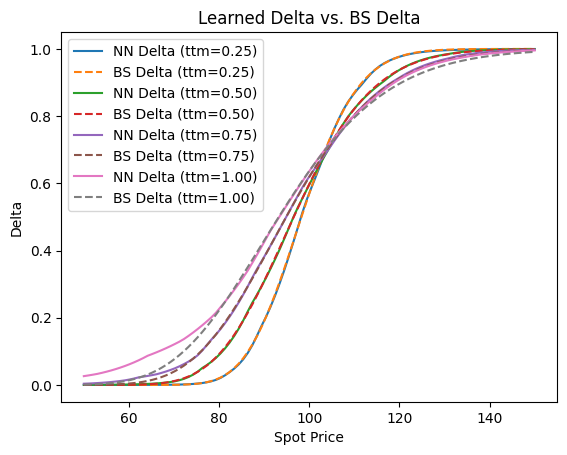

In [12]:
import matplotlib.pyplot as plt

# Choose a test grid (price, ttm, moneyness)
spots = np.linspace(0.5*K, 1.5*K, 100)
ttm_vals = np.array([0.25, 0.5, 0.75, 1.0])
for ttm_frac in ttm_vals:
    inputs = []
    for spot in spots:
        ttm = ttm_frac * T
        moneyness = spot / K
        inputs.append([spot/S0, ttm/T, moneyness])
    inputs = torch.tensor(inputs, dtype=torch.float32)
    with torch.no_grad():
        preds = model(inputs).numpy().flatten()
    # Ground truth
    bs_deltas = norm.cdf((np.log(spots/K) + (r + 0.5 * sigma**2)*ttm) / (sigma * np.sqrt(ttm+1e-8)))
    plt.plot(spots, preds, label=f"NN Delta (ttm={ttm:.2f})")
    plt.plot(spots, bs_deltas, '--', label=f"BS Delta (ttm={ttm:.2f})")

plt.xlabel("Spot Price")
plt.ylabel("Delta")
plt.title("Learned Delta vs. BS Delta")
plt.legend()
plt.show()
